[array([[0.9921147-0.12533323j, 0.       +0.j        ],
       [0.       +0.j        , 0.9921147-0.12533323j]]), array([[0.9921147+0.j        , 0.       -0.12533323j],
       [0.       -0.12533323j, 0.9921147+0.j        ]]), array([[ 0.9921147 +0.j, -0.12533323+0.j],
       [ 0.12533323+0.j,  0.9921147 +0.j]]), array([[0.9921147-0.12533323j, 0.       +0.j        ],
       [0.       +0.j        , 0.9921147+0.12533323j]])]
1.0
1.0
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000009
1.0000000000000009
1.0000000000000009
1.0000000000000013
1.0000000000000013
1.0000000000000018
1.0000000000000018
1.0000000000000018
1.0000000000000022
1.0000000000000022
1.0000000000000027
1.0000000000000027
1.000000000000003
1.000000000000003
1.000000000000003
1.0000000000000036
1.0000000000000036
1.0000000000000036
1.0000000000000044
1.0000000000000044
1.0000000000000044
1.0000000000000044
1.0000000000000044
1.0000000000000

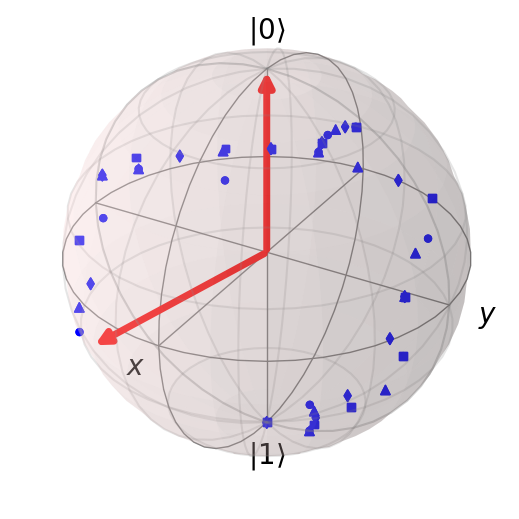

In [6]:
import numpy as np
from scipy.linalg import expm

#calc time
import time

#animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization.bloch import Bloch

#ML part
import torch


#Calculation stuff for plotting
s1 = np.array([[0, 1], [1, 0]], dtype=complex)
s2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
s3 = np.array([[1, 0], [0, -1]], dtype=complex)

def calc_location(state):
    # We assume the state is given as an array.
    npstate = np.array(state, dtype=complex)
    x = np.matmul(np.conjugate(npstate), np.matmul(s1, np.transpose(npstate))).real
    y = np.matmul(np.conjugate(npstate), np.matmul(s2, np.transpose(npstate))).real
    z = np.matmul(np.conjugate(npstate), np.matmul(s3, np.transpose(npstate))).real
    return [x, y, z]

#PLotting stuff





seed=0
np.random.seed(seed)

class QubitEnv():

    def __init__(self,seed,n_time_steps):

        self.n_time_steps=n_time_steps
        ### define action space variables
        self.n_actions = 4  # action space size
        delta_t = 2 * np.pi / self.n_time_steps  # set a value for the time step

        # define Pauli matrices
        Id = np.array([[1.0, 0.0], [0.0, +1.0]])
        sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])
        sigma_y = np.array([[0.0, -1.0j], [1.0j, 0.0]])
        sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])

        self.action_space = []
        for generator in [Id, sigma_x, sigma_y, sigma_z]:
            self.action_space.append(expm(-1j * delta_t * generator))

        print(self.action_space)
        self.actions=np.array([0,1,2,3])

        self.S_target=np.array([0.0,0.0])
        self.psi_target=self.sphere_to_qubit(self.S_target)

        self.set_seed(seed)

        self.state= self.set_state(False)
        self.psi=self.sphere_to_qubit(self.state)

    def set_seed(self,seed):
        np.random.seed(seed)

    def set_state(self,random=True):
        if random:
            theta = np.pi * np.random.uniform(0.0, 1.0)
            phi = 2 * np.pi * np.random.uniform(0.0, 1.0)
        else:
            # start from south pole of Bloch sphere
            theta = np.pi
            phi = 0.0

        self.state = np.array([theta, phi])
        self.psi = self.sphere_to_qubit(self.state)

        return self.state

    def sphere_to_qubit(self, s):
        """
        Take as input the spherical state s, and return the quantum state |psi>
        """
        theta, phi = s
        psi = np.array([np.cos(0.5 * theta), np.exp(1j * phi) * np.sin(0.5 * theta)])
        return psi

    def qubit_to_sphere(self, psi):
        """
        Take as input the quantum state |psi>, and return the spherical state s
        """
        # take away unphysical global phase
        alpha = np.angle(psi[0])
        psi_new = np.exp(-1j * alpha) * psi

        # find Bloch sphere angles
        theta = 2.0 * np.arccos(psi_new[0]).real
        phi = np.angle(psi_new[1])

        return np.array([theta, phi])

    def step(self,action):
        # apply gate to quantum state
        self.psi = self.action_space[action].dot(self.psi)
        print(np.abs(self.psi.conj().dot(self.psi)**2))
        # compute RL state
        self.state = self.qubit_to_sphere(self.psi)

        # compute reward
        reward = np.abs(self.psi_target.conj().dot(self.psi)) ** 2

        # check if state is terminal #TODO
        done = False

        return self.psi, reward, done


n_time_steps=50
Env=QubitEnv(seed,n_time_steps)
Env.set_state(False)

done = False
j = 0
psis=np.zeros((n_time_steps,2),dtype=complex)
psis[0]=Env.psi.copy()
while j < n_time_steps-1:
    # pick a random action
    action = np.random.choice([0, 1, 2, 3])  # equiprobable policy
    psi_new, reward, done = Env.step(action)
    j+=1
    psis[j]=psi_new

    if done:
        print('\nreached terminal state!')
        break


    # # pick a random action
    # action = np.random.choice([0, 1, 2, 3])  # equiprobable policy
    # # take an environment step
    # state = Env.state.copy()
    # state_p, reward, done = Env.step(action)
    # print("{}. s={}, a={}, r={}, s'={}\n".format(j, state, action, np.round(reward, 6), state_p))
    # j += 1
    # if done:
    #     print('\nreached terminal state!')
    #     break


fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
sphere = Bloch(axes=ax)

def animate(i):
    sphere.clear()
    sphere.add_vectors(calc_location(Env.psi_target))
    sphere.add_vectors(calc_location(psis[i]))
    if i>0:
        # x,y,z=zip(calc_location(psis[i]),calc_location(psis[i-1]))
        # ax.plot3D(x,y,z,'ro--')
        for j in range(i):
            sphere.add_points(calc_location(psis[j]))
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['r']
    sphere.point_color=['b']
    return ax



ani = animation.FuncAnimation(
    fig,
    animate,
    np.arange(len(psis)),
    init_func=init,
    blit=False,
    repeat=False
)
HTML(ani.to_jshtml())








